In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/My Drive/LSTM_DL

/content/drive/My Drive/LSTM_DL


In [3]:
!pip install common
!pip install --upgrade pandas
!pip install --upgrade --force-reinstall xlrd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for common: filename=common-0.1.2-py3-none-any.whl size=3731 sha256=c2f13503b30cb36f09c5d8bc0fcf55eb90766c38a853731bbea868b8782744af
  Stored in directory: /root/.cache/pip/wheels/ec/b0/bf/d38cbc0eb5079d61cc5e94280603e7b5756f502edc072c7319
Successfully built common
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 5.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.5 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninstalling xlrd-1.2.0:
      Successfully uninstalled xlrd-1.2.0


#Data 94

##data 94 전처리

In [4]:
# road data
data = pd.read_excel('data.xls')

data94 = data[(data['Part Number'] == 'Part 94')]

# clear data
data94 = data94.loc[:, ['Part Number', 'D일 투입예정 수량(D일계획)', 'D+1일 투입예정 수량(Total)', 'D+2일 투입예정 수량(Total)',
                        'D+3일 투입예정 수량(Total)', 'D+4일 투입예정 수량(Total)', 'D+5일 투입예정 수량', 'D+6일 투입예정 수량',
                        'D+7일 투입예정 수량', 'D+8일 투입예정 수량', 'D+9일 투입예정 수량', 'D+10일 투입예정 수량', 'D+11일 투입예정 수량',
                        'D+12일 투입예정 수량','CRET_TIME']]

In [5]:
data94['CRET_TIME'] = pd.to_datetime(data94['CRET_TIME'], format="%Y%m%d%H%M")

data94 = data94.groupby(by=[data94['CRET_TIME'].dt.year,
data94['CRET_TIME'].dt.month,
data94['CRET_TIME'].dt.day]).last()
data94.reset_index(drop=True, inplace=True)

##변수별 상관관계 파악을 위한 데이터 재배열

In [6]:
corr_data94 = pd.concat([
        data94.iloc[12:, :]['D일 투입예정 수량(D일계획)'].reset_index(drop=True),
        data94.iloc[11:-1, :]['D+1일 투입예정 수량(Total)'].reset_index(drop=True),
        data94.iloc[10:-2, :]['D+2일 투입예정 수량(Total)'].reset_index(drop=True),
        data94.iloc[9:-3, :]['D+3일 투입예정 수량(Total)'].reset_index(drop=True),
        data94.iloc[8:-4, :]['D+4일 투입예정 수량(Total)'].reset_index(drop=True),
        data94.iloc[7:-5, :]['D+5일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[6:-6, :]['D+6일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[5:-7, :]['D+7일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[4:-8, :]['D+8일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[3:-9, :]['D+9일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[2:-10, :]['D+10일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[1:-11, :]['D+11일 투입예정 수량'].reset_index(drop=True),
        data94.iloc[:-12, :]['D+12일 투입예정 수량'].reset_index(drop=True)
        ],
        axis=1)


##당일 발주 수량과 가장 유의미한 관계가 있는 변수 선택

In [7]:
data94 = data94.loc[:, ['D일 투입예정 수량(D일계획)',
                  'D+3일 투입예정 수량(Total)',
                  'D+4일 투입예정 수량(Total)',
                  'D+5일 투입예정 수량'
                  ]].reset_index(drop=True)
data94.head()

,D일 투입예정 수량(D일계획),D+3일 투입예정 수량(Total),D+4일 투입예정 수량(Total),D+5일 투입예정 수량
0,42,30,30,38
1,40,30,50,45
2,40,47,43,51
3,47,53,42,39
4,46,44,37,51


##사용자 지정함수로 시계열 데이터로 변환

In [8]:
def to_timeseries_data(data, lookback=3, delay=3):
    # data는 원본 tabular 데이터
    # lookback: 입력으로 사용하기 위해 거슬러 올라갈 시간단위의 개수=3일전
    # delay: target으로 사용할 미래의 시점=3일후
    output_len = len(data)-(lookback+delay)+1 # N=total_length-(3+3)+1
    n_feature = data.shape[-1] # =4
    
    inputs = np.zeros((output_len, lookback, n_feature)) # (N,3,4)
    targets = np.zeros((output_len,)) # (N,)
    
    for i in range(output_len):
        inputs[i] = data.iloc[i:i+lookback, :]
        targets[i] = data.iloc[i+lookback+delay-1, 0]
       
    return inputs, targets
# 사용자 정의 함수 적용
X_94, y_94 = to_timeseries_data(data94)
print("X의 형태: ", X_94.shape)
print("y의 형태: ", y_94.shape)

X의 형태:  (44, 3, 4)
y의 형태:  (44,)


##데이터셋 분리와 데이터 스케일링

In [9]:
# 데이터셋 분리, train:validation:test = 7:1:2
X_train_94, X_val_94, X_test_94 = np.split(X_94, [int(0.7*len(X_94)), int(0.8*len(X_94))])
y_train_94, y_val_94, y_test_94 = np.split(y_94, [int(0.7*len(y_94)), int(0.8*len(y_94))])
# 분리 이후 데이터 형태
print("X 학습: {}, X 검증: {}, X 평가: {}".format(X_train_94.shape,X_val_94.shape,X_test_94.shape))
print("y 학습: {}, y 검증: {}, y 평가: {}".format(y_train_94.shape,y_val_94.shape,y_test_94.shape))


X 학습: (30, 3, 4), X 검증: (5, 3, 4), X 평가: (9, 3, 4)
y 학습: (30,), y 검증: (5,), y 평가: (9,)


In [10]:
# 전처리시 필요한 패키지 불러오기
from sklearn.preprocessing import StandardScaler
Xscaler_94 = StandardScaler()
X_train_94 = Xscaler_94.fit_transform(X_train_94.reshape(-1, X_train_94.shape[-1])).reshape(X_train_94.shape)
X_val_94 = Xscaler_94.transform(X_val_94.reshape(-1, X_val_94.shape[-1])).reshape(X_val_94.shape)
X_test_94 = Xscaler_94.transform(X_test_94.reshape(-1, X_test_94.shape[-1])).reshape(X_test_94.shape)
yscaler_94 = StandardScaler()
y_train_94 = yscaler_94.fit_transform(y_train_94.reshape(-1,1))
y_val_94 = yscaler_94.transform(y_val_94.reshape(-1,1))
y_test_94 = yscaler_94.transform(y_test_94.reshape(-1,1))

#data 94 Build Model

In [66]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM

In [67]:
model = Sequential()
model.add(LSTM(8, dropout=0.2, activation='relu', input_shape=(3, 4), return_sequences=True))
model.add(LSTM(8, dropout=0.2, activation='relu'))
model.add(Dense(1, activation='linear'))

In [68]:
model.compile(optimizer='adam', loss='mae')

In [69]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = './model/{epoch:02d}-{val_loss:.4f}.hdf5'
callbacks = [EarlyStopping(monitor='val_loss', patience=15),
               ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=0, save_best_only=True)]
history = model.fit(X_train_94, y_train_94, epochs=100, batch_size=4, validation_data=(X_val_94, y_val_94))

Epoch 1/100
8/8 [==============================] - 8s 102ms/step - loss: 0.7835 - val_loss: 0.8368
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7658 - val_loss: 0.8368
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.7651 - val_loss: 0.8371
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.7687 - val_loss: 0.8371
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.7586 - val_loss: 0.8373
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7590 - val_loss: 0.8377
Epoch 7/100
8/8 [==============================] - 0s 18ms/step - loss: 0.7400 - val_loss: 0.8382
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7475 - val_loss: 0.8387
Epoch 9/100
8/8 [==============================] - 0s 16ms/step - loss: 0.7299 - val_loss: 0.8392
Epoch 10/100
8/8 [==============================] - 0s 14ms/step - loss: 0.7075 - val_loss: 0.8390
Epoch 11/100
8/8 [

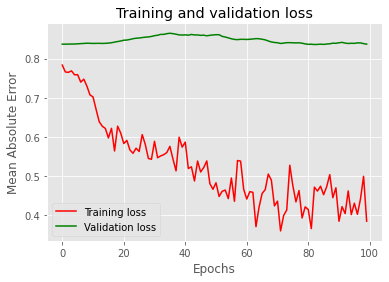

In [70]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = history.epoch
plt.figure()
plt.plot(epoch, loss, 'r', label='Training loss')
plt.plot(epoch, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [71]:
loss_and_metrics = model.evaluate(X_test_94,y_test_94)
print('##### data 94 #####')
print('loss : ',loss_and_metrics)

1/1 [==============================] - 0s 31ms/step - loss: 1.0459
##### data 94 #####
loss :  1.0459072589874268


#Data 60 66에 대한 전처리

In [20]:
# road data
data = pd.read_excel('data.xls')

data60 = data[(data['Part Number'] == 'Part 60')]
data66 = data[(data['Part Number'] == 'Part 66')]

# clear data
data60 = data60.loc[:, ['Part Number', 'D일 투입예정 수량(D일계획)', 'D+1일 투입예정 수량(Total)', 'D+2일 투입예정 수량(Total)',
                        'D+3일 투입예정 수량(Total)', 'D+4일 투입예정 수량(Total)', 'D+5일 투입예정 수량', 'D+6일 투입예정 수량',
                        'D+7일 투입예정 수량', 'D+8일 투입예정 수량', 'D+9일 투입예정 수량', 'D+10일 투입예정 수량', 'D+11일 투입예정 수량',
                        'D+12일 투입예정 수량','CRET_TIME']]
data66 = data66.loc[:, ['Part Number', 'D일 투입예정 수량(D일계획)', 'D+1일 투입예정 수량(Total)', 'D+2일 투입예정 수량(Total)',
                        'D+3일 투입예정 수량(Total)', 'D+4일 투입예정 수량(Total)', 'D+5일 투입예정 수량', 'D+6일 투입예정 수량',
                        'D+7일 투입예정 수량', 'D+8일 투입예정 수량', 'D+9일 투입예정 수량', 'D+10일 투입예정 수량', 'D+11일 투입예정 수량',
                        'D+12일 투입예정 수량','CRET_TIME']]

In [21]:
data60['CRET_TIME'] = pd.to_datetime(data60['CRET_TIME'], format="%Y%m%d%H%M")
data66['CRET_TIME'] = pd.to_datetime(data66['CRET_TIME'], format="%Y%m%d%H%M")

data60 = data60.groupby(by=[data60['CRET_TIME'].dt.year,
data60['CRET_TIME'].dt.month,
data60['CRET_TIME'].dt.day]).last()
data60.reset_index(drop=True, inplace=True)

data66 = data66.groupby(by=[data66['CRET_TIME'].dt.year,
data66['CRET_TIME'].dt.month,
data66['CRET_TIME'].dt.day]).last()
data66.reset_index(drop=True, inplace=True)

##변수별 상관관계 파악을 위한 데이터 재배열

In [22]:
corr_data60 = pd.concat([
        data60.iloc[12:, :]['D일 투입예정 수량(D일계획)'].reset_index(drop=True),
        data60.iloc[11:-1, :]['D+1일 투입예정 수량(Total)'].reset_index(drop=True),
        data60.iloc[10:-2, :]['D+2일 투입예정 수량(Total)'].reset_index(drop=True),
        data60.iloc[9:-3, :]['D+3일 투입예정 수량(Total)'].reset_index(drop=True),
        data60.iloc[8:-4, :]['D+4일 투입예정 수량(Total)'].reset_index(drop=True),
        data60.iloc[7:-5, :]['D+5일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[6:-6, :]['D+6일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[5:-7, :]['D+7일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[4:-8, :]['D+8일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[3:-9, :]['D+9일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[2:-10, :]['D+10일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[1:-11, :]['D+11일 투입예정 수량'].reset_index(drop=True),
        data60.iloc[:-12, :]['D+12일 투입예정 수량'].reset_index(drop=True)
        ],
        axis=1)

corr_data66 = pd.concat([
        data66.iloc[12:, :]['D일 투입예정 수량(D일계획)'].reset_index(drop=True),
        data66.iloc[11:-1, :]['D+1일 투입예정 수량(Total)'].reset_index(drop=True),
        data66.iloc[10:-2, :]['D+2일 투입예정 수량(Total)'].reset_index(drop=True),
        data66.iloc[9:-3, :]['D+3일 투입예정 수량(Total)'].reset_index(drop=True),
        data66.iloc[8:-4, :]['D+4일 투입예정 수량(Total)'].reset_index(drop=True),
        data66.iloc[7:-5, :]['D+5일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[6:-6, :]['D+6일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[5:-7, :]['D+7일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[4:-8, :]['D+8일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[3:-9, :]['D+9일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[2:-10, :]['D+10일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[1:-11, :]['D+11일 투입예정 수량'].reset_index(drop=True),
        data66.iloc[:-12, :]['D+12일 투입예정 수량'].reset_index(drop=True)
        ],
        axis=1)

##당일발주 수량과 가장 유의미한 관계가 있는 변수 선택

In [23]:
data60 = data60.loc[:, ['D일 투입예정 수량(D일계획)',
                  'D+3일 투입예정 수량(Total)',
                  'D+4일 투입예정 수량(Total)',
                  'D+5일 투입예정 수량'
                  ]].reset_index(drop=True)
data60.head()

,D일 투입예정 수량(D일계획),D+3일 투입예정 수량(Total),D+4일 투입예정 수량(Total),D+5일 투입예정 수량
0,898,832,832,832
1,932,872,0,0
2,961,0,0,837
3,1043,0,827,851
4,1124,0,0,0


In [24]:
data66 = data66.loc[:, ['D일 투입예정 수량(D일계획)',
                  'D+3일 투입예정 수량(Total)',
                  'D+4일 투입예정 수량(Total)',
                  'D+5일 투입예정 수량'
                  ]].reset_index(drop=True)
data66.head()

,D일 투입예정 수량(D일계획),D+3일 투입예정 수량(Total),D+4일 투입예정 수량(Total),D+5일 투입예정 수량
0,898,832,832,832
1,932,872,0,0
2,961,0,0,837
3,1043,0,827,851
4,1124,0,0,0


##사용자 지정함수로 시계열 데이터로 변환

In [37]:
def to_timeseries_data(data, lookback=3, delay=3):
    # data는 원본 tabular 데이터
    # lookback: 입력으로 사용하기 위해 거슬러 올라갈 시간단위의 개수=3일전
    # delay: target으로 사용할 미래의 시점=3일후
    output_len = len(data)-(lookback+delay)+1 # N=total_length-(3+3)+1
    n_feature = data.shape[-1] # =4
    
    inputs = np.zeros((output_len, lookback, n_feature)) # (N,3,4)
    targets = np.zeros((output_len,)) # (N,)
    
    for i in range(output_len):
        inputs[i] = data.iloc[i:i+lookback, :]
        targets[i] = data.iloc[i+lookback+delay-1, 0]
       
    return inputs, targets
    
# 사용자 정의 함수 적용
X_60, y_60 = to_timeseries_data(data60)
print("X의 형태: ", X_60.shape)
print("y의 형태: ", y_60.shape)
print("\n")
X_66, y_66 = to_timeseries_data(data66)
print("X의 형태: ", X_66.shape)
print("y의 형태: ", y_66.shape)

X의 형태:  (44, 3, 4)
y의 형태:  (44,)


X의 형태:  (44, 3, 4)
y의 형태:  (44,)


##데이터셋 분리 및 데이터 스케일링

In [38]:
# 데이터셋 분리, train:validation:test = 7:1:2
X_train_60, X_val_60, X_test_60 = np.split(X_60, [int(0.7*len(X_60)), int(0.8*len(X_60))])
y_train_60, y_val_60, y_test_60 = np.split(y_60, [int(0.7*len(y_60)), int(0.8*len(y_60))])
# 분리 이후 데이터 형태
print("X 학습: {}, X 검증: {}, X 평가: {}".format(X_train_60.shape,X_val_60.shape,X_test_60.shape))
print("y 학습: {}, y 검증: {}, y 평가: {}".format(y_train_60.shape,y_val_60.shape,y_test_60.shape))

# 데이터셋 분리, train:validation:test = 7:1:2
X_train_66, X_val_66, X_test_66 = np.split(X_66, [int(0.7*len(X_66)), int(0.8*len(X_66))])
y_train_66, y_val_66, y_test_66 = np.split(y_66, [int(0.7*len(y_66)), int(0.8*len(y_66))])
# 분리 이후 데이터 형태
print("X 학습: {}, X 검증: {}, X 평가: {}".format(X_train_66.shape,X_val_66.shape,X_test_66.shape))
print("y 학습: {}, y 검증: {}, y 평가: {}".format(y_train_66.shape,y_val_66.shape,y_test_66.shape))


X 학습: (30, 3, 4), X 검증: (5, 3, 4), X 평가: (9, 3, 4)
y 학습: (30,), y 검증: (5,), y 평가: (9,)
X 학습: (30, 3, 4), X 검증: (5, 3, 4), X 평가: (9, 3, 4)
y 학습: (30,), y 검증: (5,), y 평가: (9,)


###60번 데이터에 대한 데이터 스케일링

In [50]:
# 전처리시 필요한 패키지 불러오기
from sklearn.preprocessing import StandardScaler

Xscaler_60 = StandardScaler()
X_train_60 = Xscaler_60.fit_transform(X_train_60.reshape(-1, X_train_60.shape[-1])).reshape(X_train_60.shape)
X_val_60 = Xscaler_60.transform(X_val_60.reshape(-1, X_val_60.shape[-1])).reshape(X_val_60.shape)
X_test_60 = Xscaler_60.transform(X_test_60.reshape(-1, X_test_60.shape[-1])).reshape(X_test_60.shape)

yscaler_60 = StandardScaler()
y_train_60 = yscaler_60.fit_transform(y_train_60.reshape(-1,1))
y_val_60 = yscaler_60.transform(y_val_60.reshape(-1,1))
y_test_60 = yscaler_60.transform(y_test_60.reshape(-1,1))

###66번 데이터에 대한 데이터 스케일링

In [40]:
Xscaler_66 = StandardScaler()
X_train_66 = Xscaler_66.fit_transform(X_train_66.reshape(-1, X_train_66.shape[-1])).reshape(X_train_66.shape)
X_val_66 = Xscaler_66.transform(X_val_66.reshape(-1, X_val_66.shape[-1])).reshape(X_val_66.shape)
X_test_66 = Xscaler_66.transform(X_test_66.reshape(-1, X_test_66.shape[-1])).reshape(X_test_66.shape)

###두개의 데이터 병합

In [41]:
X_train_both = np.concatenate([X_train_60, X_train_66], axis=2)
X_val_both = np.concatenate([X_val_60, X_val_66], axis=2)
X_test_both = np.concatenate([X_test_60, X_test_66], axis=2)
print("X 학습: {}, X 검증: {}, X 평가: {}".format(X_train_both.shape, X_val_both.shape, X_test_both.shape))

X 학습: (30, 3, 8), X 검증: (5, 3, 8), X 평가: (9, 3, 8)


#data 60 Build Model

In [78]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM

In [79]:
model = Sequential()
model.add(LSTM(32, dropout=0.2, activation='relu', input_shape=(3, 4), return_sequences=True))
model.add(LSTM(16, dropout=0.2, activation='relu'))
model.add(Dense(1, activation='linear'))

In [80]:
model.compile(optimizer='adam', loss='mae')

In [81]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = './model/{epoch:02d}-{val_loss:.4f}.hdf5'
callbacks = [EarlyStopping(monitor='val_loss', patience=15),
 ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=0, save_best_only=True)]
history = model.fit(X_train_60, y_train_60, epochs=100, batch_size=4, validation_data=(X_val_60, y_val_60))


Epoch 1/100
8/8 [==============================] - 7s 95ms/step - loss: 0.8032 - val_loss: 0.1028
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.7909 - val_loss: 0.0976
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.7764 - val_loss: 0.0878
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.7684 - val_loss: 0.0801
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.7606 - val_loss: 0.0737
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.7423 - val_loss: 0.0610
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.7253 - val_loss: 0.0496
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.7117 - val_loss: 0.0584
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 0.6948 - val_loss: 0.0696
Epoch 10/100
8/8 [==============================] - 0s 15ms/step - loss: 0.6484 - val_loss: 0.0796
Epoch 11/100
8/8 [=

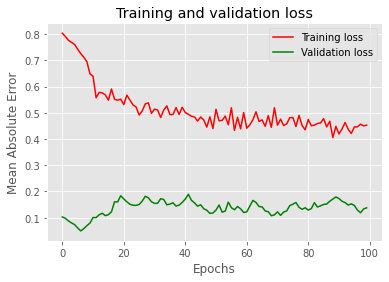

In [82]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = history.epoch
plt.figure()
plt.plot(epoch, loss, 'r', label='Training loss')
plt.plot(epoch, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [83]:
loss_and_metrics = model.evaluate(X_test_94,y_test_94)
print('##### data 94 #####')
print('loss : ',loss_and_metrics)

1/1 [==============================] - 0s 24ms/step - loss: 1.5531
##### data 94 #####
loss :  1.5531214475631714


#Data 60 66 Build Model

In [84]:
model = Sequential()
model.add(LSTM(32, dropout=0.2, activation='relu', input_shape=(3,8), return_sequences=True))
model.add(LSTM(16, dropout=0.2, activation='relu'))
model.add(Dense(1, activation='linear'))

In [85]:
model.compile(optimizer='adam', loss='mae')

In [86]:
model_path = './model_60/{epoch:02d}-{val_loss:.4f}.hdf5'
callbacks = [EarlyStopping(monitor='val_loss', patience=30),
               ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=0, save_best_only=True)]
               
history = model.fit(X_train_both, y_train_60, epochs=100, batch_size=4, validation_data=(X_val_both, y_val_60))

Epoch 1/100
8/8 [==============================] - 12s 95ms/step - loss: 0.7760 - val_loss: 0.0581
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.7514 - val_loss: 0.0506
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.7215 - val_loss: 0.0594
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.7134 - val_loss: 0.0735
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.6550 - val_loss: 0.1222
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.5797 - val_loss: 0.1659
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.5624 - val_loss: 0.2132
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 0.5931 - val_loss: 0.1744
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 0.5650 - val_loss: 0.1667
Epoch 10/100
8/8 [==============================] - 0s 15ms/step - loss: 0.5496 - val_loss: 0.1506
Epoch 11/100
8/8 [

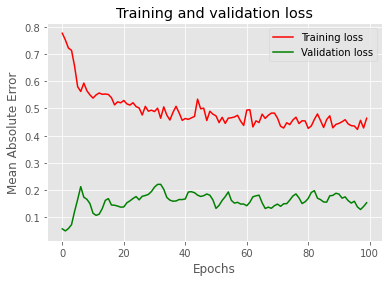

In [87]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = history.epoch

plt.figure()
plt.plot(epoch, loss, 'r', label='Training loss')
plt.plot(epoch, val_loss, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [88]:
loss_and_metrics = model.evaluate(X_test_both,y_test_60)
print('##### data 60 66 #####')
print('loss : ',loss_and_metrics)

1/1 [==============================] - 0s 24ms/step - loss: 0.6597
##### data 60 #####
loss :  0.6597006320953369
